In [1]:
import os
import numpy as np 

os.chdir("../")

In [2]:
from dataclasses import dataclass
from typing      import Dict, List, Tuple, Optional, Union

In [3]:
from src.processing.constructors.moccasurvey import MoccaSurveyExperimentConfig
from src.processing.modules.simulations      import SimulationProcessor
from src.processing.modules.processor        import DataProcessor
from src.processing.modules.downsampling     import DownsamplingProcessor

In [4]:
@dataclass
class ProcessingConfig(MoccaSurveyExperimentConfig):
    """Configuration class for processing parameters."""
    dataset_name = "moccasurvey"
    points_per_sim: Union[int, float] = 0.80  # When sampling points from simulations, how many (if float its %)
    n_virtual: int = 10                       # How many virtual simulatinos we extract from one simulation
    train_split: float = 0.7                  # The training fraction of the split
    val_split: float = 0.2                    # The validation fraction of the split
    test_split: float = 0.1                   # The testing fraction of the split
    min_points_threshold: int = 1000          # The minimun number of points to consider a simulation
    histogram_bins: int = 200                 # The number of celds for the 2D histogram
    downsample_min_count: int = 10            # Minimun number of points per celd to consider
    downsample_max_count: int = 150           # Maximun number of points per celd to consider
    requires_temp_evol: bool = False          # Whether to use initial values
    sample_window : bool = False
    retain_order : bool =True
    

# Initialize config
config   = ProcessingConfig()

# Initialize Processors
sims_processor         = SimulationProcessor(config)
data_processor         = DataProcessor(config)
downsampling_processor = DownsamplingProcessor(config)

In [5]:
simulations = sims_processor.load_simulation_data("./rawdata/moccasurvey/simulations/", load_all_sims=True)

INFO: Scanning directory: ./rawdata/moccasurvey/simulations/
INFO: Total simulation models available for analysis: 455


In [6]:
simulations_by_type = sims_processor.classify_simulations_by_environment(simulations)
path_to_label       = {path: env_type
                       for env_type, paths in simulations_by_type.items()
                       for path in paths
                       }

labels        = [path_to_label.get(path, np.nan) for path in simulations]
filtered_info = data_processor.select_suitable_sims(simulations, simulations_by_type, 
                                                    out_path = f"./rawdata/moccasurvey/")

INFO: No cache found. Classifying simulations by environment type...


Classifying simulations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [03:51<00:00,  1.97sim/s]

INFO: FAST simulations: 90
INFO: SLOW simulations: 257
INFO: Found existing filter files. Loading from disk...
INFO: Loaded 342 valid simulations from: ./rawdata/moccasurvey/valid_simulations.txt
INFO: Loaded 101 outliers from: ./rawdata/moccasurvey/outliers.txt



Processing simulations: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 443/443 [03:41<00:00,  2.00sim/s]

INFO: Filtering simulations based on perpendicular distance to fit curve (median and IQR)...
INFO: Efficiency vs Mass Ratio Filter Results:
INFO: Detected Outliers: 100 of 443 simulations.
INFO: Threshold = 1.0140 (median=0.6937, IQR=0.6405)


In [7]:
valid_sims = filtered_info['valid_sims']
outliers   = filtered_info['outliers']

In [8]:
t_val, m_val, phy_val, _ = data_processor.process_simulations(
                                      valid_sims['paths'], valid_sims['labels'],
                                      augmentation = False, 
                                      apply_noise  = False, 
                                      n_virtual    = None, 
                                      verbose      = True,
                                      study_mode   = True)

Processing simulations: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 443/443 [00:16<00:00, 26.40sim/s]

INFO: ______________________________________________________________________________________________________________
INFO: Simulation processing completed:
INFO: ______________________________________________________________________________________________________________
INFO:   - Total simulations processed   : 443
INFO:   - Simulations used              : 443
INFO:   - Simulations ignored           : 0
INFO:   - FAST formation channel sims   : 117
INFO:   - SLOW formation channel sims   : 326
INFO:   - Average points per simulation : 8393.9 ± 7054.5
INFO: ______________________________________________________________________________________________________________


In [9]:
t_out, m_out, phy_out, _ = data_processor.process_simulations(
                                      outliers['paths'], outliers['labels'],
                                      augmentation = False,
                                      apply_noise  = False, 
                                      n_virtual    = None, 
                                      verbose      = True,
                                      study_mode   = True)

Processing simulations: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.54sim/s]

INFO: ______________________________________________________________________________________________________________
INFO: Simulation processing completed:
INFO: ______________________________________________________________________________________________________________
INFO:   - Total simulations processed   : 100
INFO:   - Simulations used              : 100
INFO:   - Simulations ignored           : 0
INFO:   - FAST formation channel sims   : 35
INFO:   - SLOW formation channel sims   : 65
INFO:   - Average points per simulation : 7648.7 ± 6086.7
INFO: ______________________________________________________________________________________________________________


In [16]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, Union, Optional, Literal
from matplotlib.colors import Colormap, Normalize, BoundaryNorm, LogNorm
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_scatter_dataset(
    data_dict : Dict[str, Dict[str, Union[list, np.ndarray]]],
    x_axis_name : str,
    y_axis_name : str,
    cmap_name   : str,
    cmap        : Union[str, Colormap] = "viridis",
    figsize     : tuple = (7, 5),
    title       : Optional[str] = None,
    cmap_label  : str = "Color value",
    s_valid     : float = 10,
    s_outlier   : float = 30,
    norm_mode   : Literal["linear", "log", "discrete"] = "linear",
    log_vmin    : Optional[float] = None,
    n_bins      : int = 6,
    savepath    : Optional[str] = None,
    show        : bool = False
):
 

    # ------------------------------------------------------------------
    # Extract data
    # ------------------------------------------------------------------
    x_valid = np.asarray(data_dict["valid_sims"][x_axis_name])
    y_valid = np.asarray(data_dict["valid_sims"][y_axis_name])
    c_valid = np.asarray(data_dict["valid_sims"][cmap_name])

    x_out   = np.asarray(data_dict["outliers"][x_axis_name])
    y_out   = np.asarray(data_dict["outliers"][y_axis_name])
    c_out   = np.asarray(data_dict["outliers"][cmap_name])

    # ------------------------------------------------------------------
    # Global color normalization
    # ------------------------------------------------------------------
    c_all         = np.concatenate([c_valid, c_out])
    cmap_obj      = cm.get_cmap(cmap)
    cb_ticks      = None
    cb_ticklabels = None
    cb_spacing    = "uniform"

    if norm_mode == "linear":
        norm = Normalize(vmin=c_all.min(), vmax=c_all.max())
        cb_spacing = "uniform"

    elif norm_mode == "log":
        if np.any(c_all <= 0):
            raise ValueError("LogNorm requires cmap_values > 0.")

        vmin = log_vmin if log_vmin is not None else np.percentile(c_all, 1)
        norm = LogNorm(vmin=vmin, vmax=c_all.max())
        cb_spacing = "uniform"

    elif norm_mode == "discrete":
        bounds = np.linspace(c_all.min(), c_all.max(), n_bins + 1)
        norm = BoundaryNorm(bounds, n_bins)
        cb_spacing = "proportional"

    elif norm_mode == "categorical":
        categories = np.unique(c_all)
        n_cat      = len(categories)
        cmap_obj   = cm.get_cmap(cmap, n_cat)

        cat_to_idx = {cat: i for i, cat in enumerate(categories)}

        c_valid = np.array([cat_to_idx[v] for v in c_valid])
        c_out   = np.array([cat_to_idx[v] for v in c_out])

        bounds = np.arange(-0.5, n_cat + 0.5, 1)
        norm   = BoundaryNorm(bounds, n_cat)

        cb_ticks      = np.arange(n_cat)
        cb_ticklabels = categories

    else:
        raise ValueError(f"Unknown norm_mode: {norm_mode}")

    # ------------------------------------------------------------------
    # Figure
    # ------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize)

    if title:
        ax.set_title(title, loc="left", fontsize=14)

    # Outliers
    ax.scatter(x_out, y_out,
               c          = c_out,
               cmap       = cmap_obj,
               norm       = norm,
               s          = s_outlier,
               marker     = "x",
               linewidths = 0.8,
               label      = fr"Outliers ({len(x_out)})")

    # Valid simulations
    sc_valid = ax.scatter(x_valid, y_valid,
                          c        = c_valid,
                          cmap      = cmap_obj,
                          norm      = norm,
                          s         = s_valid,
                          marker    ="o",
                          edgecolor ="none",
                          label     =fr"Valid sims ({len(x_valid)})")

    # Axes
    ax.set_xscale("log")
    #ax.set_yscale("log")
    
    ax.set_ylim(top=1.0)
    
    ax.set_xlabel(r"$M_{\rm tot,i}/M_{\rm crit}$", fontsize=12)
    ax.set_ylabel(r"$M_{\rm tot,f}/M_{\rm tot,i}$", fontsize=12)

    # ------------------------------------------------------------------
    # Colorbar
    # ------------------------------------------------------------------
    cax = inset_axes(ax, width="50%", height="4%", loc="upper left", borderpad=1)

    cb = fig.colorbar(sc_valid, cax=cax, orientation="horizontal",
                      spacing=cb_spacing,
                      ticks=cb_ticks)

    if cb_ticklabels is not None:
        cb.set_ticklabels(cb_ticklabels)
    
    cb.set_label(cmap_label, fontsize=10)
    cb.ax.tick_params(labelsize=8)

    # ------------------------------------------------------------------
    # Save / show
    # ------------------------------------------------------------------
    if savepath:
        plt.savefig(savepath, dpi=700, bbox_inches="tight")

    if show:
        plt.show()

    plt.close(fig)

In [11]:
valid_sims['rho_half'] = np.array([entry[0][11] for entry in phy_val])

outliers['rho_half'] = np.array([entry[0][11] for entry in phy_out])

/tmp/ipykernel_46/2618859864.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj      = cm.get_cmap(cmap)
/tmp/ipykernel_46/2618859864.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj   = cm.get_cmap(cmap, n_cat)


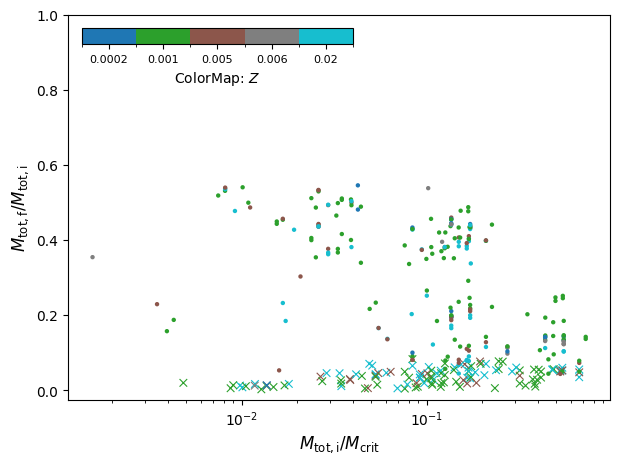

In [18]:
plot_scatter_dataset(data_dict = {'valid_sims': valid_sims, 'outliers': outliers},
                     x_axis_name = 'f_mass',
                     y_axis_name = 'f_fin',
                     cmap_name   = 'z',
                     cmap        = "tab10",
                     figsize     = (7, 5),
                     title       = None,
                     cmap_label  = r"ColorMap: $Z$",
                     norm_mode   = "categorical",
                     n_bins      = 7,
                     show        = True,
                     savepath    = "./cosas.jpg",)

In [22]:
valid_sims['m_loss'] = np.array([entry[0][12] for entry in phy_val])
outliers['m_loss']  =  np.array([entry[0][12] for entry in phy_out])

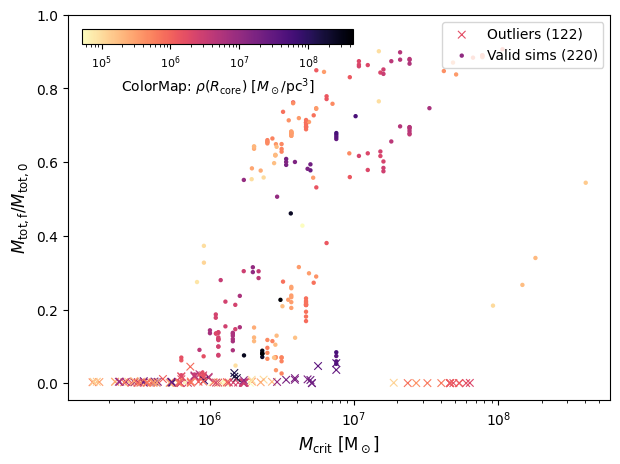

In [16]:
plot_scatter_dataset(data_dict = {'valid_sims': valid_sims, 'outliers': outliers},
                     x_axis_name = 'm_crit',
                     y_axis_name = 'f_obj',
                     cmap_name   = 'rho_core',
                     cmap        = "magma_r",
                     figsize     = (7, 5),
                     title       = None,
                     cmap_label  = r"ColorMap: $\rho(R_{\rm core})$ $[M_\odot/\text{pc}^3]$",
                     norm_mode   = "log",
                     show        = True,
                     savepath    = "./fobj_mcrit_rhocore.jpg",)

In [23]:
w0_val = []
for a in valid_sims["paths"]:
    wo = a.split("w0")[1]
    w0_val.append(float(str(wo[1:4])))

valid_sims['w0'] = w0_val

w0_out = []
for a in outliers["paths"]:
    wo = a.split("w0")[1]
    w0_out.append(float(str(wo[1:4])))

outliers['w0'] = w0_out

In [13]:
import astropy.units as u

# External functions and utilities ----------------------------------------------------------------------------------------#
from typing  import Optional, Union, Tuple
from astropy import constants as c

In [153]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, Union, Optional, Literal
from matplotlib.colors import Colormap, Normalize, BoundaryNorm, LogNorm
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import gaussian_kde


def plot_efficiency_mass_ratio_dataset(
    data_dict               : Dict[str, Dict[str, Union[list, np.ndarray]]],
    figsize                 : tuple                                                         = (7, 5),
    title                   : Optional[str]                                                 = None,
    cmap_label              : Optional[str]                                                 = None,
    cmap                    : Optional[Union[str, Colormap]]                                = None,
    cmap_name               : Optional[str]                                                 = None,
    norm_mode               : Optional[Literal["linear", "log", "discrete", "categorical"]] = "linear",
    n_bins                  : Optional[int]                                                 = 6,
    log_vmin                : Optional[float]                                               = None,
    include_historical_sims : bool                                                          = False,
    include_historical_obs  : bool                                                          = False,
    savepath                : Optional[str]                                                 = None,
    show                    : bool                                                          = False
    ):
    # ------------------------------------------------------------------
    # Fit from Vergara et al. (2025)
    # ------------------------------------------------------------------
    def V2025_epsilon_BH(m_ratio: np.ndarray,
                        k: float = 4.63,
                        x0: float = 4.0,
                        a: float = -0.1):
        X = np.log(m_ratio)
        return (1 + np.exp(-k * (X - x0)))**a

    # ------------------------------------------------------------------
    # Prepare data
    # ------------------------------------------------------------------
    tags = list(data_dict.keys())

    # Collect all cmap values globally if a colormap is requested
    if cmap is not None:
        c_all = []
        for tag in tags:
            if cmap_name not in data_dict[tag]:
                raise ValueError(f"Group '{tag}' is missing but a cmap {cmap_name}.")
            c_all.append(np.asarray(data_dict[tag][cmap_name]))
        c_all = np.concatenate(c_all)

        cmap_obj      = cm.get_cmap(cmap)
        cb_ticks      = None
        cb_ticklabels = None
        cb_spacing    = "uniform"

        if norm_mode == "linear":
            norm = Normalize(vmin=c_all.min(), vmax=c_all.max())

        elif norm_mode == "log":
            if np.any(c_all <= 0):
                raise ValueError("LogNorm requires cmap_values > 0.")
            vmin = log_vmin if log_vmin is not None else np.percentile(c_all, 1)
            norm = LogNorm(vmin=vmin, vmax=c_all.max())

        elif norm_mode == "discrete":
            bounds     = np.linspace(c_all.min(), c_all.max(), n_bins + 1)
            norm       = BoundaryNorm(bounds, n_bins)
            cb_spacing = "proportional"

        elif norm_mode == "categorical":
            categories = np.unique(c_all)
            n_cat      = len(categories)
            cmap_obj   = cm.get_cmap(cmap, n_cat)

            cat_to_idx = {cat: i for i, cat in enumerate(categories)}
            bounds     = np.arange(-0.5, n_cat + 0.5, 1)
            norm       = BoundaryNorm(bounds, n_cat)

            cb_ticks      = np.arange(n_cat)
            cb_ticklabels = categories

            # Remap cmap values to category indices
            for tag in tags:
                vals = np.asarray(data_dict[tag]["cmap_values"])
                data_dict[tag]["_cmap_mapped"] = np.array([cat_to_idx[v] for v in vals])

        else:
            raise ValueError(f"Unknown norm_mode: {norm_mode}")

    # ------------------------------------------------------------------
    # Figure
    # ------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize)

    if title:
        ax.set_title(title, loc="left", fontsize=14)

    #Load historical data ---------------------------------------------
    if include_historical_sims:
        _plot_historical_contours(
        ax,
        "./rawdata/historical/V25.txt",
        mini=0,
        maxi=162,
        color="paleturquoise",
        prob_levels=(0.50, 0.65, 0.8),
        label="sims",)

    if include_historical_obs:
        _plot_historical_contours(
        ax,
        "./rawdata/historical/V25.txt",
        mini=163,
        maxi=-1,
        color="thistle",
        prob_levels=(0.50, 0.65, 0.8),
        label="obs",)
    # ------------------------------------------------------------------
    # Scatter plots (one per tag)
    # ------------------------------------------------------------------
    last_scatter = None

    for tag in tags:

        # Retrieve group
        group = data_dict[tag]

        # Set variables
        x = np.asarray(group["mass_ratio"])
        y = np.asarray(group["epsilon"])

        # Retrieve configuration
        marker    = group.get("marker", "o")
        color     = group.get("color", None)
        edgecolor = group.get("edgecolor", "none")
        s         = group.get("s", 30)
        label     = group.get("label", tag)

        if cmap is None:
            sc = ax.scatter(x, y, s=s, marker=marker, c=color, edgecolor=edgecolor,label=label+f" ({len(x)})")
        else:
            if norm_mode == "categorical":
                cvals = group["_cmap_mapped"]
            else:
                cvals = np.asarray(group[cmap_name])

            sc = ax.scatter(x, y, s=s, marker=marker, c=cvals, cmap=cmap_obj, norm=norm, edgecolor=edgecolor, 
                            label=label+f" ({len(x)})")

        last_scatter = sc  # for colorbar handle

    # ------------------------------------------------------------------
    # Fit curve
    # ------------------------------------------------------------------
    xx = np.logspace(-5, 4)
    ax.plot(xx, V2025_epsilon_BH(xx), "--", color="black", lw=1.0, label="Fit from Vergara+25")

    # ------------------------------------------------------------------
    # Axes
    # ------------------------------------------------------------------
    ax.set_xscale("log")
    ax.set_xlim(1e-5, 1e4)
    ax.set_ylim(bottom=-0.05, top=1.05)
    ax.set_xlabel(r"$M_{\rm tot}/M_{\rm crit}$", fontsize=12)
    ax.set_ylabel(r"$\epsilon_{\rm BH}$", fontsize=12)

    # ------------------------------------------------------------------
    # Colorbar (only if cmap is provided)
    # ------------------------------------------------------------------
    if cmap is not None:
        cax = inset_axes(ax, width="50%", height="4%", loc="upper left", borderpad=1)

        cb = fig.colorbar(
            last_scatter,
            cax=cax,
            orientation="horizontal",
            spacing=cb_spacing,
            ticks=cb_ticks
        )

        if cb_ticklabels is not None:
            cb.set_ticklabels(cb_ticklabels)

        cb.set_label(cmap_label, fontsize=10)
        cb.ax.tick_params(labelsize=8)

    # ------------------------------------------------------------------
    # Legend
    # ------------------------------------------------------------------
    ax.legend(loc="lower right", fontsize=8)

    # ------------------------------------------------------------------
    # Save / Show
    # ------------------------------------------------------------------
    if savepath:
        plt.savefig(
            savepath + "efficiency_vs_mass_ratio.jpg",
            dpi=700,
            bbox_inches="tight"
        )

    if show:
        plt.show()

    plt.close(fig)
    

In [151]:
def _plot_historical_contours(
    ax,
    filepath,
    mini,
    maxi,
    color,
    label,
    alpha=0.3,
    prob_levels=(0.6, 0.7, 0.8, 0.90),
    linewidths=0.8,
    linestyles="dotted",
    bw_method=0.21
):
    data = np.genfromtxt(filepath, delimiter=",", names=True)

    x = data["mass_ratio"][mini:maxi]
    y = data["epsilon"][mini:maxi]

    # KDE in log-x space (important for log axis)
    X = np.log10(x)
    Y = y
    values = np.vstack([X, Y])

    kde = gaussian_kde(values, bw_method=bw_method)

    # Evaluation grid
    pad_x = 0.05 * (X.max() - X.min())
    pad_y = 0.05 * (Y.max() - Y.min())

    x_grid = np.linspace(X.min() - pad_x, X.max() + pad_x, 400)
    y_grid = np.linspace(Y.min() - pad_y, Y.max() + pad_y, 400)
    Xg, Yg = np.meshgrid(x_grid, y_grid)
    positions = np.vstack([Xg.ravel(), Yg.ravel()])

    Z = np.reshape(kde(positions).T, Xg.shape)
    
    # ---- Compute probability contour levels ----
    Z_flat = Z.ravel()
    idx_sort = np.argsort(Z_flat)[::-1]   # high → low
    Z_sorted = Z_flat[idx_sort]

    cumsum = np.cumsum(Z_sorted)
    cumsum /= cumsum[-1]  # normalize to 1

    levels = []
    for p in prob_levels:
        i = np.searchsorted(cumsum, p)
        levels.append(Z_sorted[i])

    levels = np.sort(levels)  # must be increasing for contour()

    # Convert back to linear x for plotting
    Xg_plot = 10**Xg

    
    # Filled contours
    cf = ax.contourf(
        Xg_plot,
        Yg,
        Z,
        levels=[*levels, Z.max()],
        colors=[color],
        alpha=alpha,
        antialiased=True,
        zorder=0
    )
    
    # Line contours
    cl = ax.contour(
        Xg_plot,
        Yg,
        Z,
        levels=levels,
        colors=[color],
        linewidths=linewidths,
        linestyles=linestyles,
        zorder=1
    )

    # Dummy handle for legend
    label_txt = f"{label}"
    ax.scatter([], [], color=color, alpha=alpha, label=label_txt)

    return cf, cl


In [38]:
outliers['mtot'] = np.array([entry[0][5]for entry in phy_out])

In [39]:
outliers['mloss'] = np.array([entry[0][9]for entry in phy_out])

In [20]:
valid_sims['epsilon_1'] = np.array([(mmo[-1]/ (entry[0][5]-entry[0][9]) )
                           for entry, mmo in zip(phy_val, m_val)])

outliers['epsilon_1'] = np.array([(mmo[-1]/ (entry[0][5]-entry[0][9]) )
                           for entry, mmo in zip(phy_out, m_out)])

In [15]:
valid_sims['chform'] = np.array([entry[0][-1] for entry in phy_val])
outliers['chform']   = np.array([entry[0][-1] for entry in phy_out])

In [147]:
valid_sims['marker']    = 'o'
valid_sims['color']     = 'navy'
valid_sims['edgecolor'] = 'white'
valid_sims['s']         = 20

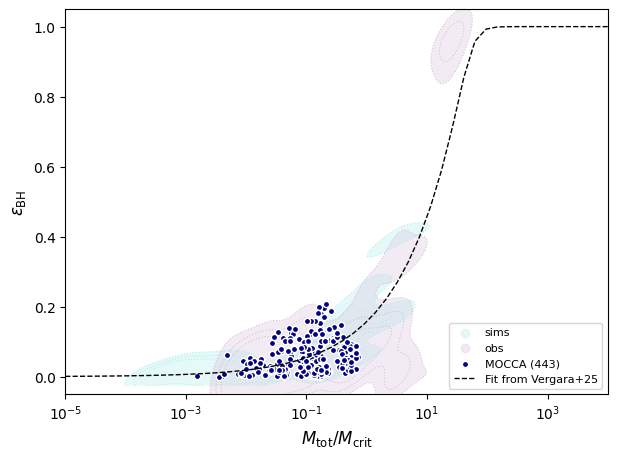

In [154]:
plot_efficiency_mass_ratio_dataset(data_dict= {'MOCCA': valid_sims},
                                   cmap       = None,
                                   
                                   cmap_name  = None,
                                   figsize    = (7, 5),
                                   cmap_label = None,
                                   norm_mode  = None,
                                   include_historical_sims=True,
                                   include_historical_obs =True,
                                   show       = True,
                                   savepath   = None,)